Importación y Carga de Datos

In [2]:
# Importaciones correctas
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

df = pd.read_csv('Telco Churn dataset 2.csv')

Preprocesamiento

In [3]:
# 1. Preprocesamiento
# a. Crear la columna 'Churn' y asignar 1 si 'Churn' es 'Yes', de lo contrario 0
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# b. Eliminar columnas con más del 50% de datos faltantes
threshold = int(0.5 * len(df))
df = df.dropna(thresh=threshold, axis=1)

# c. Reemplazar valores atípicos por la media
for col in df.select_dtypes(include=['float64', 'int64']):
    if col != 'Churn':  # Asegurarse de no modificar la columna 'Churn'
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].apply(lambda x: df[col].mean() if (x < (Q1 - 1.5 * IQR)) or (x > (Q3 + 1.5 * IQR)) else x)

# d. Convertir variables categóricas a numéricas y llenar valores faltantes
for column in df.columns:
    if df[column].dtype == 'object' and column != 'Churn':
        df[column].fillna(df[column].mode()[0], inplace=True)
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    elif df[column].dtype in ['int64', 'float64']:
        df[column].fillna(df[column].median(), inplace=True)

# e. Normalización
cols_to_scale = df.columns.tolist()
cols_to_scale.remove('Churn')
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# f. Asegurarse de que 'Churn' sea int
df['Churn'] = df['Churn'].astype(int)


Selección de características

In [4]:
# 2. Selección de características
xgb_for_feature_selection = XGBClassifier(
    objective='binary:logistic', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
xgb_for_feature_selection.fit(df.drop('Churn', axis=1), df['Churn'])
threshold = 0.01  
selected_features = df.drop('Churn', axis=1).columns[(xgb_for_feature_selection.feature_importances_ > threshold)].tolist()
print("Características seleccionadas:", selected_features)

Características seleccionadas: ['customerID', 'SeniorCitizen', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'InternationalPlan', 'VoiceMailPlan', 'NumbervMailMessages', 'TotalDayMinutes', 'TotalEveMinutes', 'TotalNightMinutes', 'TotalIntlMinutes', 'TotalIntlCalls', 'CustomerServiceCalls']


Balanceo con SMOTE

In [5]:
# 3. Balanceo con SMOTE
X = df[selected_features]
y = df['Churn']
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

División de Conjunto

In [6]:
# 4. División de Conjunto
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

Inicializar modelos con los hiperparámetros óptimos encontrados

In [7]:
# 5. Inicializar modelos con los hiperparámetros óptimos encontrados
xgb_model = XGBClassifier(
    subsample=0.9,
    scale_pos_weight=1,
    reg_lambda=50.0,
    n_estimators=300,
    max_depth=8,
    learning_rate=0.3,
    gamma=0,
    colsample_bytree=0.9,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

svc_model = SVC(
    kernel='rbf',
    gamma=0.1,
    C=10,
    probability=True,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=5,
    min_samples_leaf=1,
    max_depth=8,
    bootstrap=False,
    random_state=42
)

Crear un Voting Classifier con soft voting

In [8]:
# 7. Crear un Voting Classifier con soft voting
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('svm', svc_model), ('rf', rf_model)],
    voting='soft'
)

Entrenar el Voting Classifier

In [9]:
# 8. Entrenar el Voting Classifier
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

Evaluar el modelo

In [10]:
# 9. Evaluar el modelo
# Calcular e imprimir la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Calcular e imprimir el informe de clasificación
report = classification_report(y_test, y_pred)
print("\nInforme de Clasificación:")
print(report)

# Calcular e imprimir la precisión del modelo
acc = accuracy_score(y_test, y_pred)
print("\nPrecisión del modelo híbrido:", acc)

Matriz de Confusión:
[[555  20]
 [ 11 554]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       575
           1       0.97      0.98      0.97       565

    accuracy                           0.97      1140
   macro avg       0.97      0.97      0.97      1140
weighted avg       0.97      0.97      0.97      1140


Precisión del modelo híbrido: 0.9728070175438597


Calcular la Curva ROC

In [11]:
# 10. Calcular la Curva ROC
y_pred_proba = voting_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

Visualizar la Curva ROC

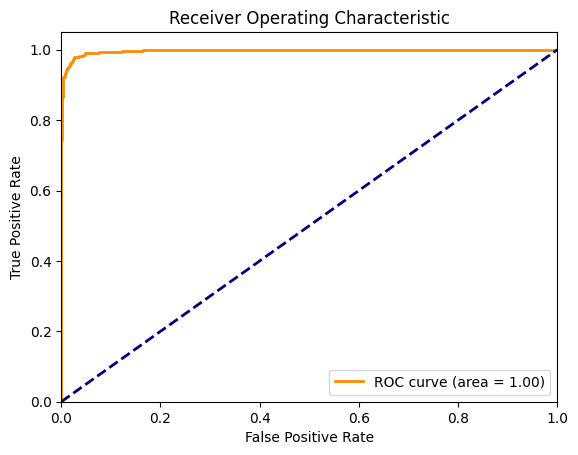

In [12]:
# 11. Visualizar la Curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()